In [5]:
%pylab inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatma

Populating the interactive namespace from numpy and matplotlib


In [19]:
import os, sys
caffe_root = os.environ['HOME'] + "/progs/caffe/"
sys.path.append(caffe_root+"python")
import caffe

In [17]:
# get data
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    os.chdir(caffe_root)
    !scripts/download_model_binary.py models/bvlc_reference_caffenet


...100%, 232 MB, 485 KB/s, 491 seconds passed

### Set up the model and network

In [20]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)


In [21]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR


mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [22]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

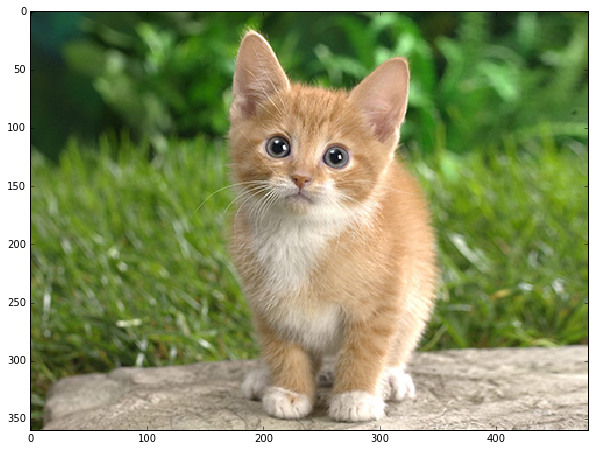

In [23]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [24]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 281


In [27]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02123045 tabby, tabby cat


In [28]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31230336, 'n02123045 tabby, tabby cat'),
 (0.23794773, 'n02123159 tiger cat'),
 (0.12388107, 'n02124075 Egyptian cat'),
 (0.10085059, 'n02119022 red fox, Vulpes vulpes'),
 (0.070990957, 'n02127052 lynx, catamount')]

### Let's look at other layers
For each layer, let's look at the activation shapes, which typically have the form (batch_size, channel_dim, height, width).

The activations are exposed as an OrderedDict, net.blobs.

In [31]:
print "___for each layer, show the output shape___"
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

___for each layer, show the output shape___
data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


Let's look at the parameter shapes. The parameters are as well another OrderedDict, net.params. [0] for Weights, and [1] for biases.

They have typically the shape of: (output_channels, input_channels, filter_height, filter_width) for the weights, and the 1-dim biases (output_channels).

In [32]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [34]:
# visualizing parts of the 4-d data (rectangular heatmaps)
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

First Layer only


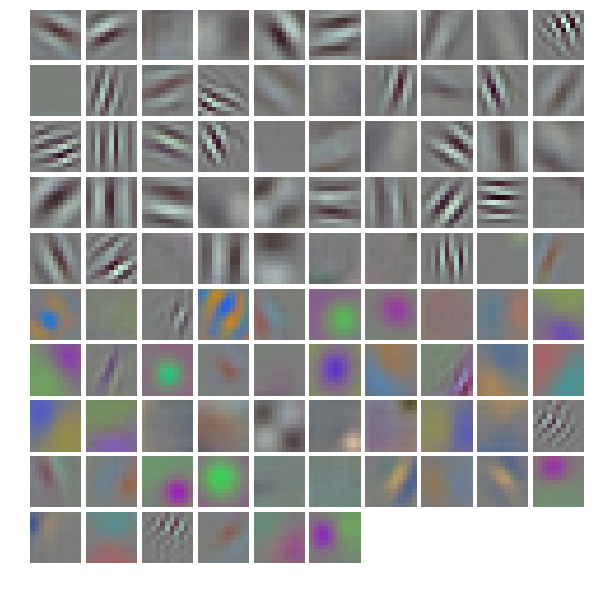

In [35]:
print "First Layer only"
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

Visualize corresponding features


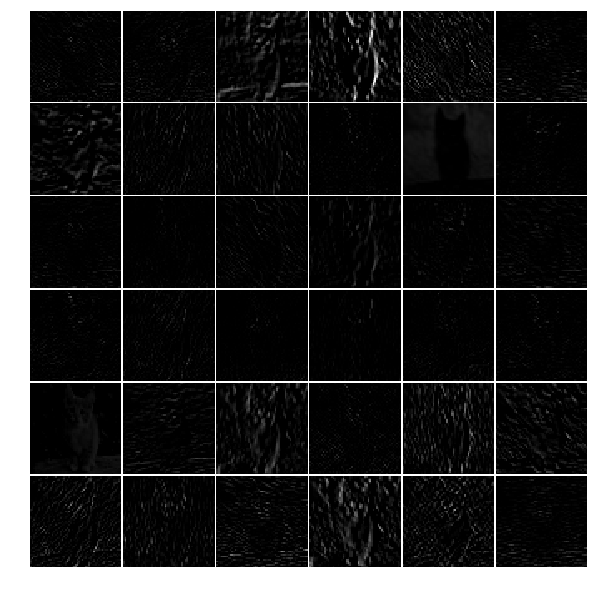

In [36]:
print "Visualize corresponding features"
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

The 5-th Layer after pooling - pool5


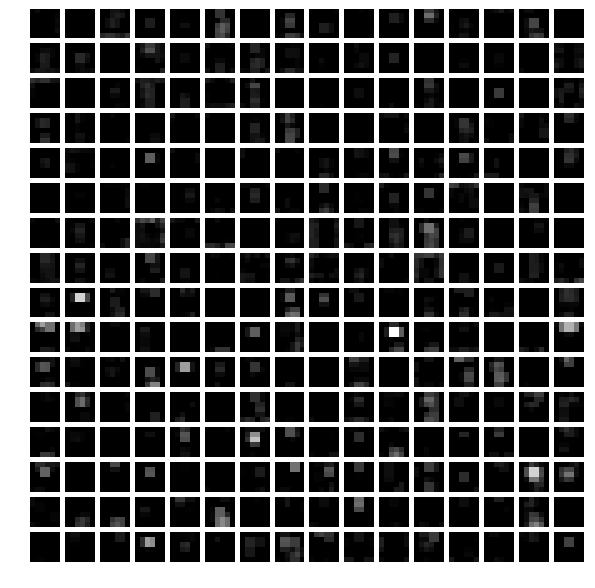

In [37]:
print "The 5-th Layer after pooling - pool5"
feat = net.blobs['pool5'].data[0]
vis_square(feat)

The first fully connected layer, fc6 (rectified)


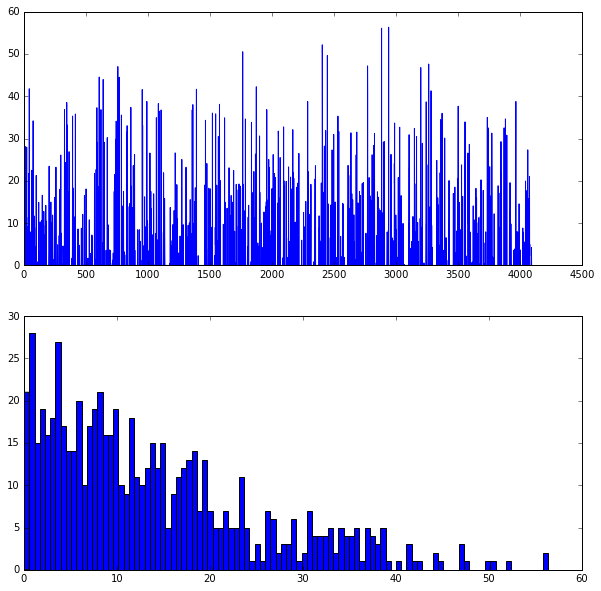

In [38]:
print "The first fully connected layer, fc6 (rectified)"
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, prob


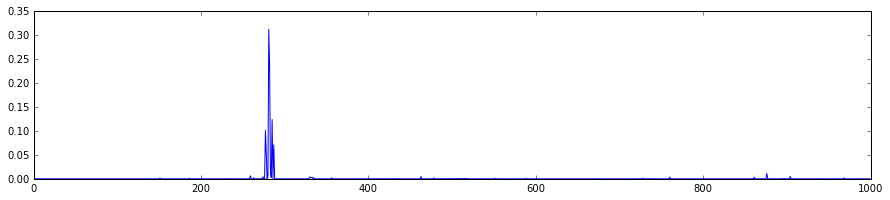

In [39]:
print "The final probability output, prob"
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

### And now, try any arbitrary image

--2016-05-11 20:35:55--  http://ucpcentralmn.org/wp-content/uploads/2015/12/desktop-computer.jpg
Resolving ucpcentralmn.org... 199.180.185.115
Connecting to ucpcentralmn.org|199.180.185.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95439 (93K) [image/jpeg]
Saving to: 'image.jpg'

image.jpg           100%[===================>]  93.20K   185KB/s    in 0.5s    

2016-05-11 20:35:56 (185 KB/s) - 'image.jpg' saved [95439/95439]

probabilities and labels:


[(0.79272509, 'n03180011 desktop computer'),
 (0.1017502, 'n03782006 monitor'),
 (0.075089172, 'n04152593 screen, CRT screen'),
 (0.020807967, 'n03085013 computer keyboard, keypad'),
 (0.0075713582, 'n03793489 mouse, computer mouse')]

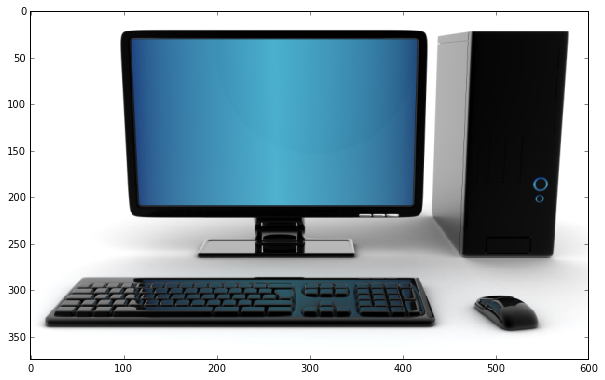

In [42]:
# download an image
my_image_url = "..."  # paste your URL here
# for example:
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
my_image_url = "http://ucpcentralmn.org/wp-content/uploads/2015/12/desktop-computer.jpg"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])
